# Convolutional RBM (cRBM)

This notebook takes care of implementing the basic functionality for cRBMs.
Or maybe it's just for the preliminaries, that is some simple stuff before it actually comes to the Boltzmann Machine.


## Part 1: Reading the data and converting it to various forms of matrices

In [508]:
%matplotlib inline

# Theano imports
import theano
import theano.tensor as T
import theano.tensor.nnet.conv as conv
from theano.tensor.shared_randomstreams import RandomStreams
from theano.sandbox.rng_mrg import MRG_RandomStreams as RS
from theano import pp

# numpy and python classics
import numpy as np
import random
import time

# biopython stuff
import Bio.SeqIO as sio
import Bio.motifs.matrix as mat
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio import motifs

# plotting
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

### Classes to read biological files (such as FASTA or JASPAR)

In [509]:
"""
This class reads sequences from fasta files.
To use it, create an instance of that object and use
the function readSequencesFromFile.
"""
class FASTAReader:
    
    def __init__(self, _path):
        self.path = _path
        
    def readSequencesFromFile (self, filename):
        dhsSequences = []
        for dhs in sio.parse(open(filename), 'fasta', IUPAC.unambiguous_dna):
            dhsSequences.append(dhs.seq)
        return dhsSequences
    
    
class JASPARReader:
    
    def __init__ (self):
        pass
    
    def readSequencesFromFile (self, filename):
        matrices = []
        for mat in motifs.parse(open(filename), 'jaspar'):
            matrices.append(mat.pwm)
        return matrices

In [510]:
matReader = JASPARReader()
pwms = matReader.readSequencesFromFile('data/jaspar_matrices.txt')

In [511]:
# apply the two classes to calculate a forward pass in our algorithm
seqReader = FASTAReader('.')
allSeqs = seqReader.readSequencesFromFile('data/wgEncodeAwgDnaseUwAg10803UniPk.fa')

In [512]:
data = [allSeqs[random.randrange(0,len(allSeqs))] for i in range(20000)]
train_set, test_set = train_test_split(data, test_size=0.25)
print "Training set size: " + str(len(train_set))
print "Test set size: " + str(len(test_set))

Training set size: 15000
Test set size: 5000


In [513]:
def getIntToLetter (letter):
    if letter == 'A' or letter == 'a':
        return 0
    elif letter == 'C' or letter == 'c':
        return 1
    elif letter == 'G' or letter == 'g':
        return 2
    elif letter == 'T' or letter == 't':
        return 3
    else:
        print "ERROR. LETTER " + letter + " DOES NOT EXIST!"
        return -1

def getMatrixFromSeq (seq):
    m = len(seq.alphabet.letters)
    n = len(seq)
    result = np.zeros((1, m, n))
    revSeq = seq.reverse_complement()
    for i in range(len(seq)):
        result[0,getIntToLetter(seq[i]),i] = 1
    return result


start = time.time()
trainingData = np.array([getMatrixFromSeq(t) for t in train_set])
testingData = np.array([getMatrixFromSeq(t) for t in test_set])
print "Conversion of test set in (in ms): " + str((time.time()-start)*1000)

Conversion of test set in (in ms): 2917.16718674


## Part 2a: Borrowing Ian Goodfellow's implementation of the probabilistic max pooling layer
This implementation is now part of the pylearn2 library which is licensed under the 3-claused BSD license.
Source code is available here: https://github.com/lisa-lab/pylearn2/blob/master/pylearn2/expr/probabilistic_max_pooling.py

In [514]:

from theano.gof.op import get_debug_values

def max_pool(z, pool_shape, top_down=None, theano_rng=None):
    """
    Probabilistic max-pooling
    Parameters
    ----------
    z : theano 4-tensor
        a theano 4-tensor representing input from below
    pool_shape : tuple
        tuple of ints. the shape of regions to be pooled
    top_down : theano 4-tensor, optional
        a theano 4-tensor representing input from above
        if None, assumes top-down input is 0
    theano_rng : MRG_RandomStreams, optional
        Used for random numbers for sampling
    Returns
    -------
    p : theano 4-tensor
        the expected value of the pooling layer p
    h : theano 4-tensor
        the expected value of the detector layer h
    p_samples : theano 4-tensor, only returned if theano_rng is not None
        samples of the pooling layer
    h_samples : theano 4-tensor, only returned if theano_rng is not None
        samples of the detector layer
    Notes
    ------
    all 4-tensors are formatted with axes ('b', 'c', 0, 1).
    This is for maximum speed when using theano's conv2d
    to generate z and top_down, or when using it to infer conditionals of
    other layers using the return values.
    Detailed description:
    Suppose you have a variable h that lives in a Conv2DSpace h_space and
    you want to pool it down to a variable p that lives in a smaller
    Conv2DSpace p.
    This function does that, using non-overlapping pools.
    Specifically, consider one channel of h. h must have a height that is a
    multiple of pool_shape[0] and a width that is a multiple of pool_shape[1].
    A channel of h can thus be broken down into non-overlapping rectangles
    of shape pool_shape.
    Now consider one rectangular pooled region within one channel of h.
    I now use 'h' to refer just to this rectangle, and 'p' to refer to
    just the one pooling unit associated with that rectangle.
    We assume that the space that h and p live in is constrained such
    that h and p are both binary and p = max(h). To reduce the state-space
    in order to make probabilistic computations cheaper we also
    constrain sum(h) <= 1.
    Suppose h contains k different units. Suppose that the only term
    in the model's energy function involving h is -(z*h).sum()
    (elemwise multiplication) and the only term in
    the model's energy function involving p is -(top_down*p).sum().
    Then P(h[i] = 1) = softmax( [ z[1], z[2], ..., z[k], -top_down] )[i]
    and P(p = 1) = 1-softmax( [z[1], z[2], ..., z[k], -top_down])[k]
    This variation of the function assumes that z, top_down, and all
    return values use Conv2D axes ('b', 'c', 0, 1).
    This variation of the function implements the softmax using a
    theano graph of exp, maximum, sub, and div operations.
    Performance notes:
    It might be possible to make a faster implementation with different
    theano ops. rather than using set_subtensor, it might be possible
    to use the stuff in theano.sandbox.neighbours. Probably not possible,
    or at least nasty, because that code isn't written with multiple
    channels in mind, and I don't think just a reshape can fix it.
    Some work on this in galatea.cond.neighbs.py
    At some point images2neighbs' gradient was broken so check that
    it has been fixed before sinking too much time into this.
    Stabilizing the softmax is also another source of slowness.
    Here it is stabilized with several calls to maximum and sub.
    It might also be possible to stabilize it with
    T.maximum(-top_down,T.signal.downsample.max_pool(z)).
    Don't know if that would be faster or slower.
    Elsewhere in this file I implemented the softmax with a reshape
    and call to Softmax / SoftmaxWithBias.
    This is slower, even though Softmax is faster on the GPU than the
    equivalent max/sub/exp/div graph. Maybe the reshape is too expensive.
    Benchmarks show that most of the time is spent in GpuIncSubtensor
    when running on gpu. So it is mostly that which needs a faster
    implementation. One other way to implement this would be with
    a linear.Conv2D.lmul_T, where the convolution stride is equal to
    the pool width, and the thing to multiply with is the hparts stacked
    along the channel axis. Unfortunately, conv2D doesn't work right
    with stride > 2 and is pretty slow for stride 2. Conv3D is used to
    mitigate some of this, but only has CPU code.
    """

    z_name = z.name
    if z_name is None:
        z_name = 'anon_z'

    batch_size, ch, zr, zc = z.shape

    r, c = pool_shape

    zpart = []

    mx = None

    if top_down is None:
        t = 0.
    else:
        t = - top_down
        t.name = 'neg_top_down'

    for i in xrange(r):
        zpart.append([])
        for j in xrange(c):
            cur_part = z[:, :, i:zr:r, j:zc:c]
            if z_name is not None:
                cur_part.name = z_name + '[%d,%d]' % (i, j)
            zpart[i].append(cur_part)
            if mx is None:
                mx = T.maximum(t, cur_part)
                if cur_part.name is not None:
                    mx.name = 'max(-top_down,' + cur_part.name + ')'
            else:
                max_name = None
                if cur_part.name is not None:
                    mx_name = 'max(' + cur_part.name + ',' + mx.name + ')'
                mx = T.maximum(mx, cur_part)
                mx.name = mx_name
    mx.name = 'local_max(' + z_name + ')'

    pt = []

    for i in xrange(r):
        pt.append([])
        for j in xrange(c):
            z_ij = zpart[i][j]
            safe = z_ij - mx
            safe.name = 'safe_z(%s)' % z_ij.name
            cur_pt = T.exp(safe)
            cur_pt.name = 'pt(%s)' % z_ij.name
            pt[-1].append(cur_pt)

    off_pt = T.exp(t - mx)
    off_pt.name = 'p_tilde_off(%s)' % z_name
    denom = off_pt

    for i in xrange(r):
        for j in xrange(c):
            denom = denom + pt[i][j]
    denom.name = 'denom(%s)' % z_name

    off_prob = off_pt / denom
    p = 1. - off_prob
    p.name = 'p(%s)' % z_name

    hpart = []
    for i in xrange(r):
        hpart.append([pt_ij / denom for pt_ij in pt[i]])

    h = T.alloc(0., batch_size, ch, zr, zc)

    for i in xrange(r):
        for j in xrange(c):
            h.name = 'h_interm'
            h = T.set_subtensor(h[:, :, i:zr:r, j:zc:c], hpart[i][j])

    h.name = 'h(%s)' % z_name

    if theano_rng is None:
        return p, h
    
    ### --------------------- DONE IF NO SAMPLES ARE GENERATED ---------------------------###
    else:
        events = []
        for i in xrange(r):
            for j in xrange(c):
                events.append(hpart[i][j])
        events.append(off_prob)

        events = [event.dimshuffle(0, 1, 2, 3, 'x') for event in events]

        events = tuple(events)

        stacked_events = T.concatenate(events, axis=4)

        rows = zr // pool_shape[0]
        cols = zc // pool_shape[1]
        outcomes = pool_shape[0] * pool_shape[1] + 1
        assert stacked_events.ndim == 5
        for se, bs, r, c, chv in get_debug_values(stacked_events, batch_size,
                                                  rows, cols, ch):
            assert se.shape[0] == bs
            assert se.shape[1] == r
            assert se.shape[2] == c
            assert se.shape[3] == chv
            assert se.shape[4] == outcomes
        reshaped_events = stacked_events.reshape((
            batch_size * rows * cols * ch, outcomes))

        multinomial = theano_rng.multinomial(pvals=reshaped_events,
                                             dtype=p.dtype)

        reshaped_multinomial = multinomial.reshape((batch_size, ch, rows,
                                                    cols, outcomes))

        h_sample = T.alloc(0., batch_size, ch, zr, zc)

        idx = 0
        for i in xrange(r):
            for j in xrange(c):
                h_sample = T.set_subtensor(h_sample[:, :, i:zr:r, j:zc:c],
                                           reshaped_multinomial[:, :, :, :,
                                           idx])
                idx += 1

        p_sample = 1 - reshaped_multinomial[:, :, :, :, -1]

        return p, h, p_sample, h_sample



In [515]:
## PART 3: Optimizing theano to do it all on the GPU

class CRBM:

    def __init__ (self, _motifLength, _numMotifs, _learningRate=0.1, _poolingFactor=1, _alphabet=IUPAC.unambiguous_dna):
        # parameters for the motifs
        self.motifLength = _motifLength
        self.numMotifs = _numMotifs
        self.alphabet = _alphabet
        self.initializeMotifs()
        
        # cRBM parameters (2*x to respect both strands of the DNA)
        b = np.random.rand(1, 2*self.numMotifs).astype(np.float32)
        c = np.random.rand(1, 4).astype(np.float32)
        self.bias = theano.shared(value=b, name='bias', borrow=True)
        self.c = theano.shared(value=c, name='c', borrow=True)
        self.poolingFactor = _poolingFactor
        self.learningRate = _learningRate
        
        # infrastructural parameters
        self.theano_rng = RS(seed=1234)
        self.params = [self.motifs, self.bias, self.c]
        self.debug = False
    
    
    def initializeMotifs (self):
        # create random motifs (2*self.numMotifs to respect both strands)
        x = np.random.rand(2 * self.numMotifs, 1, 4, self.motifLength).astype(np.float32)
        
        # create reverse complement
        for i in range(self.numMotifs):
            x[self.numMotifs+i] = np.flipud(np.fliplr(x[self.numMotifs+i]))
            
        self.motifs = theano.shared(value=x, name='W', borrow=True)
        
        
    def setCustomKernels (self, customKernels):
        if len(customKernels.shape) != 4 or customKernels.shape[1] != 1:
            print "New motifs must be a 4D matrix with dims: (K x 1 x numOfLetters(4) x numOfKMers)"
            return
        
        self.numMotifs = customKernels.shape[0]
        self.motifLength = customKernels.shape[3]
        #b = np.random.rand(1, self.numMotifs).astype(np.float32)
        
        if self.debug:
            b = np.zeros((1, self.numMotifs)).astype(np.float32)
            c = np.zeros((1, 4)).astype(np.float32)
        else:
            b = np.random.rand(1, self.numMotifs).astype(np.float32)
            c = np.random.rand(1, 4).astype(np.float32)

        self.bias = theano.shared(value=b, name='bias', borrow=True)
        self.c = theano.shared(value=c, name='c', borrow=True)
        
        self.motifs = theano.shared(value=customKernels.astype(np.float32))
        self.params = [self.motifs, self.bias, self.c]
        print "New motifs set. # Motifs: " + str(self.numMotifs) + " K-mer-Length: " + str(self.motifLength)

        
### ------------------------------THE TOUGH STUFF-------------------------------- ###
### ----------------------------------------------------------------------------- ###

    def forwardBatch (self, data):
        out = conv.conv2d(data, self.motifs)#:,:,::-1,::-1] # flip, because conv reverts H
        if self.debug:
            out = theano.printing.Print('Convolution result forward: ')(out)
        out = out.mean(axis=2, keepdims=True)
        bMod = self.bias
        bMod = bMod.dimshuffle('x', 1, 0, 'x') # add dims to the bias until it works
        out = out + bMod
        pooled = max_pool(out.dimshuffle(0,2,1,3), pool_shape=(2, self.poolingFactor), theano_rng=self.theano_rng)
        H = pooled[1]
        S = pooled[3]
        return [H,S] #only return pooled layer and probs


    def backwardBatch (self, H_sample):
        K = self.motifs.dimshuffle(1, 0, 2, 3)[:,:,::-1,::-1]
        H_shuffled = H_sample.dimshuffle(0, 2, 1, 3) # interpret the kernels as channels (will be summed automatically)
        C = conv.conv2d(H_shuffled, K, border_mode='full')
        if self.debug:
            C = theano.printing.Print('Pre sigmoid visible layer: ')(C)
        out = T.sum(C, axis=1, keepdims=True) # sum over all K
        c_bc = self.c
        c_bc = c_bc.dimshuffle('x', 0, 1, 'x')
        out = out + c_bc
        
        # add fourth dimension (the strands) that was lost during forward pass
        res = self.softmax(out)
        return res


    def gradient (self, hiddenProbs, data):
        mean = T.mean(hiddenProbs, axis=0, keepdims=True) # sum over all training data to get avg (but keep dim)
        H_reshaped = mean.dimshuffle(2, 0, 1, 3)
        out = conv.conv2d(data, H_reshaped)
        return T.mean(out, axis=0, keepdims=True).dimshuffle(1, 0, 2, 3) #mean over all training samples

    
    def performGibbsSampling (self, Sample_H):
        #theano.printing.Print('Sample')(Sample_H)
        V_model = self.backwardBatch(Sample_H)
        S_v = self.sampleVisibleLayer(V_model)
        [H_model, S_model] = self.forwardBatch(S_v)
        return [H_model, S_model]
        
        
    def getTrainingFunction (self, numOfCDs):
        D = T.tensor4('data')
        # calculate the data gradient for weights (motifs) and bias
        [H_data, S_data] = self.forwardBatch(D)
        if self.debug:
            H_data = theano.printing.Print('Hidden Layer Probabilities: ')(H_data)
        # calculate data gradients
        G_motif_data = self.gradient(H_data, D)
        G_bias_data = T.mean(T.sum(H_data, axis=3), axis=0)
        G_c_data = T.mean(T.sum(D, axis=3), axis=0)
        
        if self.debug:
            G_motif_data = theano.printing.Print('Gradient for motifs (data): ')(G_motif_data)
        # calculate model probs
        S_H = S_data
        for i in range(numOfCDs):
            V_model = self.backwardBatch(S_H)
            S_V_model = self.sampleVisibleLayer(V_model)
            [H_model, S_H] = self.forwardBatch(S_V_model)
        
        # compute the model gradients
        G_motif_model = self.gradient(H_model, D)
        G_bias_model = T.mean(T.sum(H_model, axis=3), axis=0)
        G_c_model = T.mean(T.sum(S_V_model, axis=3), axis=0)
        if self.debug:
            G_motif_model = theano.printing.Print('Gradient for motifs (model): ')(G_motif_model)
        
        # update the parameters
        new_motifs = self.motifs + self.learningRate * (G_motif_data - G_motif_model)
        new_bias = self.bias + self.learningRate * (G_bias_data - G_bias_model)
        new_c = self.c + self.learningRate * (G_c_data - G_c_model)
        
        #score = self.getDataReconstruction(D)
        updates = [(self.motifs, new_motifs), (self.bias, new_bias), (self.c, new_c)]
        fun = theano.function([D],
                              [],
                              updates = updates,
                              allow_input_downcast=True,
                              on_unused_input='ignore')
        return fun
    
    
    def trainMinibatch (self, trainData, testData, epochs, batchSize, numOfCDs):
        
        # assert that pooling can be done without rest to the division
        assert (((trainData.shape[3] - self.motifLength + 1) % self.poolingFactor) == 0)
        assert (((testData.shape[3] - self.motifLength + 1) % self.poolingFactor) == 0)
        
        itPerEpoch = trainData.shape[0] / batchSize
        print "BatchSize: " + str(batchSize)
        print "Num of iterations per epoch: " + str(itPerEpoch)
        start = time.time()
        trainingFun = self.getTrainingFunction(numOfCDs)
        reconFun = self.getReconFun()
        #reconstructionFun = self.getDataReconstructionFunction()
        print "Compilation of theano function finished in " + str(time.time()-start) + " seconds"
        print "Start training..."
        start = time.time()
        allScores = []
        for epoch in range(epochs):
            smallScores = []
            for batch in range(itPerEpoch):
                trainingFun(trainData[batch*batchSize:(batch+1)*batchSize])
            allScores.append(reconFun(testData))
            print "[Epoch " + str(epoch) + "] Reconstruction Error: " + str(allScores[-1])
        print "Training finished after: " + str(time.time()-start) + " seconds!"
        return allScores

    def getReconFun (self):
        D = T.tensor4('data')
        score = self.getDataReconstruction(D)
        return theano.function([D], score, allow_input_downcast=True)
    
    
    def getDataReconstruction (self, D):
        [H, S_H] = self.forwardBatch(D)
        V = self.backwardBatch(S_H)
        S_V = self.sampleVisibleLayer(V)
        diff = (T.argmax(D, axis=3) - T.argmax(S_V, axis=3))
        diff = abs(diff)
        score = diff.mean(axis=0) # mean over all training samples
        score = score.sum()
        return score
    
 
    def sampleVisibleLayer (self, V):
        reshaped = V.dimshuffle(0, 1, 3, 2).reshape((V.shape[0]*V.shape[3], V.shape[2]))
        S_reshaped = self.theano_rng.multinomial(n=1,pvals=reshaped)
        S = S_reshaped.reshape((V.shape[0], 1, V.shape[3], V.shape[2])).dimshuffle(0, 1, 3, 2)
        S = S.astype('float32')
        return S
    
    def softmax (self, x):
        return T.exp(x) / T.exp(x).sum(axis=2, keepdims=True)

## Part 4b: Create the theano functions neccessary for training (compile to C)
Theano optimizes the function graph heavily when aiming for maximum performance. Thus, the package spends a long time setting up the whole system and not so much time with the actual training of the data.

By generating the function in it's own cell, we can do training seperately.

In [516]:
# set some config parameters to make debugging simpler
debug = True
if debug:
    np.set_printoptions(precision=2, suppress=True)
    theano.config.exception_verbosity='high'
    theano.config.optimizer='None'
    theano.config.compute_test_value='ignore'
    theano.config.profile=True
else:
    theano.config.exception_verbosity='low'
    theano.config.mode='FAST_RUN'


Kernel shape: [[[[1 0 0]
   [0 1 0]
   [0 0 1]
   [0 0 0]]]


 [[[0 0 0]
   [1 0 0]
   [0 1 0]
   [0 0 1]]]]
Data shape: (1, 1, 4, 8)
Shape.0
BatchSize: 1
Num of iterations per epoch: 1
Compilation of theano function finished in 1.57087206841 seconds
Start training...
Training finished after: 0.262718200684 seconds!
Training (with compilation) performed in: 1.83835101128 seconds.
Result from training: 
----------------------
Learned Motif: 
[[[[ 0.63  0.45  0.47]
   [ 0.87  0.22  0.8 ]
   [ 0.24  0.01  0.47]
   [ 0.7   0.78  0.38]]]


 [[[ 0.22  0.6   0.7 ]
   [ 0.99  0.32  0.35]
   [ 0.62  0.88  0.75]
   [ 0.7   0.2   0.86]]]


 [[[ 0.53  0.17  0.65]
   [ 0.39  0.11  0.86]
   [ 0.89  0.49  0.79]
   [ 0.41  0.36  0.06]]]


 [[[ 0.76  0.06  0.28]
   [ 0.32  0.89  0.39]
   [ 0.14  0.36  0.34]
   [ 0.57  0.73  0.74]]]]
Learned Bias (b): 
[[ 0.78  0.93  0.99  0.25]]
Learned Constant (c): 
[[ 0.59  0.92  0.89  0.38]]


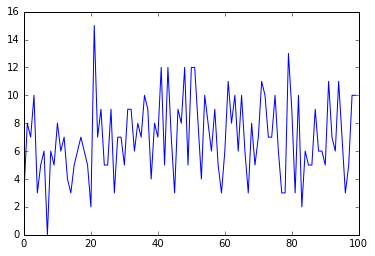

In [517]:
theano.config.profile=True

#initialize the learner and set custom kernels
x = CRBM(3, 2, .00001, 1)
kernel1 = np.tile(np.array([[1,0,0],[0,1,0],[0,0,1],[0,0,0]]), [1,1,1])
kernel1_ = np.tile(np.flipud(np.fliplr(kernel1[0])),[1,1,1])
kernel2 = np.tile(np.array([[0,0,0],[0,0,0],[1,1,1],[0,0,0]]), [1,1,1])
kernel2_ = np.tile(np.flipud(np.fliplr(kernel2[0])), [1,1,1])
kernel3 = np.random.rand(1,4,3)
kernel3_ = np.tile(np.flipud(np.fliplr(kernel3[0])), [1,1,1])
kernel = np.array([kernel1, kernel1_])#, kernel2, kernel2_])#, kernel3, kernel3_])
#kernel = np.array([kernel3, kernel3_])
print "Kernel shape: " + str(kernel)

# initialize the data
randSeq1 = getMatrixFromSeq(Seq("ACGTGGGG", IUPAC.unambiguous_dna))
randSeq2 = getMatrixFromSeq(Seq("ACGTACGT", IUPAC.unambiguous_dna))
data = np.array([randSeq1], dtype=np.float32)
print "Data shape: " + str(data.shape)
#x.setCustomKernels(kernel)
print x.motifs.shape


# perform training on our test data
start = time.time()
scores = x.trainMinibatch(data, data, 100, 1, 5)
print "Training (with compilation) performed in: " + str(time.time()-start) + " seconds."
print "Result from training: "
print "----------------------"
print "Learned Motif: "
print x.motifs.get_value()
print "Learned Bias (b): "
print x.bias.get_value()
print "Learned Constant (c): "
print x.c.get_value()
plt.plot(scores)
plt.show()

## Part 4: Test our GPU solution on the "real" training set
It's time now to test on some real data to see how good the training is.

In [ ]:
theano.config.mode='FAST_RUN'
theano.config.profile=True

learner = CRBM(3, 20, 0.0001, 2)
print "Data mat shape: " + str(trainingData.shape)
start = time.time()
scores = learner.trainMinibatch(trainingData, testingData, 10, 300, 5)
print "Training of " + str(trainingData.shape[0]) + " performed in: " + str(time.time()-start) + " seconds."
plt.plot(scores)
plt.ylabel('Average Reconstruction Error')
plt.xlabel('Number Of Epoch')
plt.show()


Data mat shape: (15000, 1, 4, 150)
BatchSize: 300
Num of iterations per epoch: 50
Compilation of theano function finished in 1.70139408112 seconds

### Plot some dummy data to learn about plotting